<a href="https://colab.research.google.com/github/EnesAgirman/ArUco_Markers/blob/main/uva_padova_t1d_open_source.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/jxx123/simglucose.git

  Cloning https://github.com/jxx123/simglucose.git to /tmp/pip-req-build-ihpw_qjc
  Running command git clone --filter=blob:none --quiet https://github.com/jxx123/simglucose.git /tmp/pip-req-build-ihpw_qjc
  Resolved https://github.com/jxx123/simglucose.git to commit a6f6777586c860457a2a1e6cce6d0bd3fd33d1cc
  Preparing metadata (setup.py) ... done


In [13]:
from simglucose.simulation.scenario_gen import RandomScenario
from simglucose.simulation.sim_engine import SimObj, sim
from simglucose.simulation.scenario import CustomScenario, Action
from simglucose.simulation.env import T1DSimEnv as RawSimEnv
from simglucose.controller.basal_bolus_ctrller import BBController
from simglucose.controller.base import Action as InsulinAction
from simglucose.patient.t1dpatient import T1DPatient
from simglucose.sensor.cgm import CGMSensor
from simglucose.actuator.pump import InsulinPump
from simglucose.envs.simglucose_gym_env import T1DSimEnv
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import pkg_resources

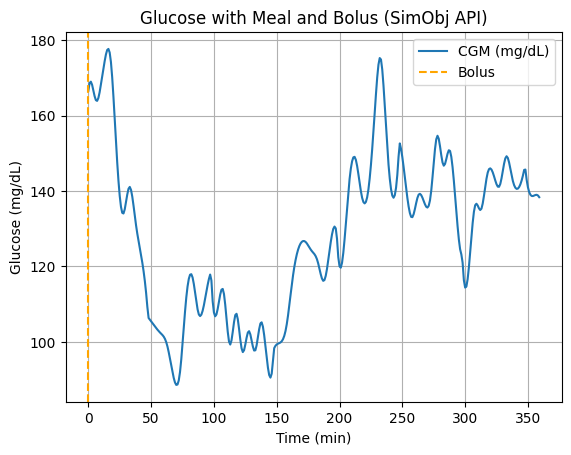

In [17]:
# basal_u_hr = 1.5
# basal_rate = basal_u_hr / 60.0 # conversion from U/hour to U/minute, so we divide by 60

# Load patient parameters
param_file = pkg_resources.resource_filename("simglucose", "params/vpatient_params.csv")
params = pd.read_csv(param_file)

# Choose a specific patient
name = 'adult#003'
row = params[params.Name == name]
u2ss = row.u2ss.values[0]  # pmol/(L·kg)
BW = row.BW.values[0]      # kg

# Compute physiological basal rate
basal_u_min = u2ss * BW / 6000  # U/min
basal_u_hr = basal_u_min * 60   # U/hr
bolus_units = 3.0
bolus_time = 0
meal_carb = 60.0

# ====== Define CustomScenario ======
start_time = datetime(2018, 1, 1)
meal_schedule = [(0, meal_carb)]  # meal at t = 0, meal_carb(gram) CHO
scenario = CustomScenario(start_time=start_time,
                          scenario=[(0, meal_carb)])

# ====== Create low-level simulator components ======
patient = T1DPatient.withName("adult#003")
sensor = CGMSensor.withName("Dexcom")
pump = InsulinPump.withName("Insulet")
env = RawSimEnv(patient, sensor, pump, scenario)

# SimObj = main simulation object
sim = SimObj(env, controller=None, sim_time=360)


log = {
    "min": [], "datetime": [], "CGM": [], "meal": [],
    "basal": [], "bolus": [], "BG": [], "Risk": []
}

env.reset()

for t in range(360):
    time = env.time

    if t == bolus_time:
        action = InsulinAction(basal=basal_u_min, bolus=bolus_units)
    else:
        action = InsulinAction(basal=basal_u_min, bolus=0.0)

    obs, reward, done, info = env.step(action)

    log["min"].append(t)
    log["datetime"].append(time)
    log["CGM"].append(obs.CGM)
    log["meal"].append(info["meal"])
    log["basal"].append(action.basal)
    log["bolus"].append(action.bolus)
    log["BG"].append(info["bg"])
    log["Risk"].append(info["risk"])

df = pd.DataFrame(log)

# ====== Plot CGM Trace ======
plt.plot(df["min"], df["CGM"], label="CGM (mg/dL)")
plt.axvline(bolus_time, color="orange", linestyle="--", label="Bolus")
plt.title("Glucose with Meal and Bolus (SimObj API)")
plt.xlabel("Time (min)")
plt.ylabel("Glucose (mg/dL)")
plt.grid()
plt.legend()
plt.show()
